<p>I experiment with 3 different models for image classification: SVN, Gradient Boosting, and CNN.  CNN is the obvious best choice primarily because it has feature extraction baked in.  
    
<p>Ultimataly, none of these models will work in the final product.  This is because the final product will require object detection, and I think also, object identification.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import glob
from PIL import Image
import pandas as pd
from numpy import asarray
import matplotlib as mpl
from skimage.feature import hog
import mahotas
from numpy import histogram
from numpy import histogram_bin_edges
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.metrics import roc_curve, auc

<p>I have configured my image data and bounding box coordinates in Yolo format.  I have been experimenting w/ Yolov4 for 
object detection. For this exercise of experimenting w/ different models, I load the image files and crop the clover images within based on the yolo bounding box coordinates.  I then rotate each clover 90, 180, and 270 degrees to create more samples.  

In [3]:
# load all of the images and labels and yolo coordinates
path = "data/yolo/"
clover = []
labels = []
files = glob.glob(path+'*.png')


for f in files:
    im = Image.open(f)
    df = pd.read_csv(f[:-4]+'.txt', delimiter=' ', header=None, names=['class','x','y','w','h'])
    for i in df.index:
      
        x = df['x'][i]
        y = df['y'][i]
        w = df['w'][i]
        h = df['h'][i]

        width, height = im.size
        left = x * width - (w*width / 2)
        top = y * height - (h * height / 2)
        bottom = top + (h * height)
        right = left + (w * width)
        
        #rotate 90,180,270
        temp = im.crop((left,top,right,bottom))
        
        for j in range(4):

            image_array= asarray(temp)
            clover.append(cv2.resize(image_array, dsize=(60,60), interpolation=cv2.INTER_CUBIC))
            labels.append(df['class'][i])
        
            temp = temp.rotate(90) 

len(clover)

8672

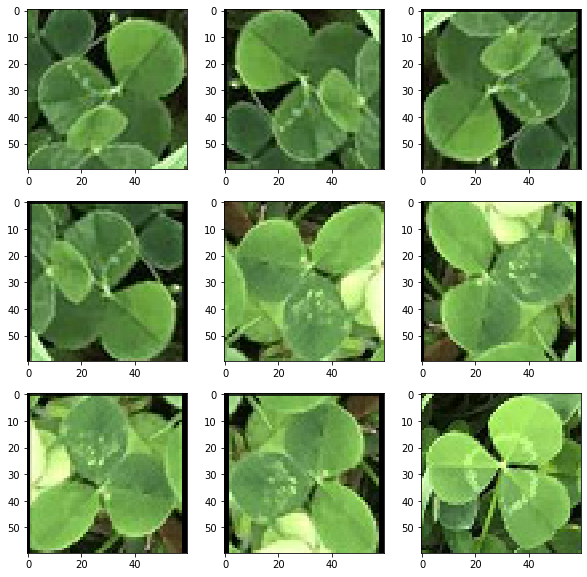

In [4]:
# plot some of the images
f, axarr = plt.subplots(3,3, figsize=(10,10))

for i in range(3):
    for j in range(3):
        axarr[i,j].imshow(clover[3*i+j])
        


In [5]:
#convert images to grey scale
from skimage.color import rgb2grey

grey_clover = []
for c in clover:
    grey_clover.append(rgb2grey(c))


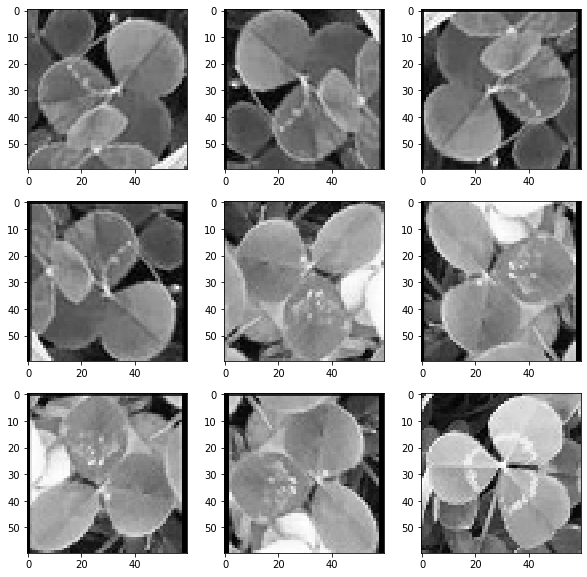

In [6]:
# plot some of the greyscale clover
f, axarr = plt.subplots(3,3, figsize=(10,10))

for i in range(3):
    for j in range(3):
        axarr[i,j].imshow(grey_clover[3*i+j], cmap=mpl.cm.gray)
        

In [7]:
#histogram of oriented gradients

hog_features, hog_image = hog(grey_clover[0], visualize=True, block_norm='L2-Hys', pixels_per_cell=(10,10))

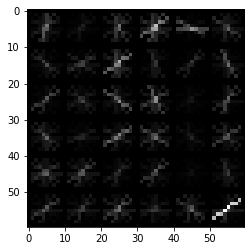

In [8]:

plt.imshow(hog_image, cmap=mpl.cm.gray)


In [9]:
def create_features(img):
    color_features = img.flatten()
    grey_image = rgb2grey(img)
    hog_features, hog_image = hog(grey_clover[0], visualize=True, block_norm='L2-Hys', pixels_per_cell=(10,10))
    flat_features = np.hstack([color_features, hog_features])

    return flat_features
    

<p>I create a feature matrix for testing SVN and Gradient Decent

In [10]:

features_list = []
for c in clover:
    features_list.append(create_features(c))

feature_matrix = np.array(features_list)
print(feature_matrix.shape)


(8672, 12096)


<p>I use PCA to reduce the feature set to 500 components

In [11]:
# get shape of feature matrix
print('Feature matrix shape is: ', feature_matrix.shape)

# define standard scaler
ss = StandardScaler()
# run this on our feature matrix
bees_stand = ss.fit_transform(feature_matrix)

pca = PCA(n_components=500)
# use fit_transform to run PCA on our standardized matrix
bees_pca = pca.fit_transform(bees_stand)
# look at new shape
print('PCA matrix shape is: ', bees_pca.shape)



Feature matrix shape is:  (8672, 12096)
PCA matrix shape is:  (8672, 500)


In [20]:
X = pd.DataFrame(bees_pca)
y = pd.Series(labels)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=.3,
                                                    random_state=1234123)

# look at the distrubution of labels in the train set
pd.Series(y_train).value_counts()

0    3532
1    2538
dtype: int64

<h3>Fit SVN Model </h3>

In [21]:
# define support vector classifier
svm = SVC(kernel='linear', probability=True, random_state=42)

# fit model
svm.fit(X_train, y_train)


SVC(kernel='linear', probability=True, random_state=42)

In [22]:
# generate predictions
y_pred = svm.predict(X_test)

# calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Model accuracy is: ', accuracy)

Model accuracy is:  0.8508839354342813


In [13]:
def calculate_auc(probabilities):

    # predict probabilities for X_test using predict_proba



    # select the probabilities for label 1.0
    y_proba = probabilities[:, 1]

    # calculate false positive rate and true positive rate at different thresholds
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_proba, pos_label=1)

    # calculate AUC
    roc_auc = auc(false_positive_rate, true_positive_rate)

    plt.title('Receiver Operating Characteristic')
    # plot the false positive rate on the x axis and the true positive rate on the y axis
    roc_plot = plt.plot(false_positive_rate,
                        true_positive_rate,
                        label='AUC = {:0.2f}'.format(roc_auc))

    plt.legend(loc=0)
    plt.plot([0,1], [0,1], ls='--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

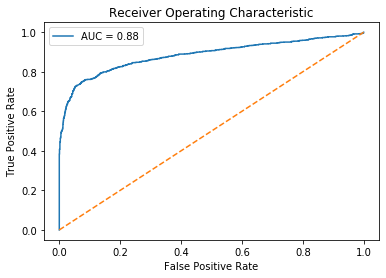

In [23]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

probabilities = svm.predict_proba(X_test)

calculate_auc(probabilities)

<h3>Fit Gradient Decent Model </h3>

In [14]:
# Gradient Boosting Classifier
from sklearn.datasets import make_classification
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split

clf = GradientBoostingClassifier(random_state=0)
clf.fit(X_train, y_train)



GradientBoostingClassifier(random_state=0)

In [47]:
# calculate accuracy
# generate predictions
y_pred = clf.predict(X_test)

# calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Model accuracy is: ', accuracy)



Model accuracy is:  0.890937019969278


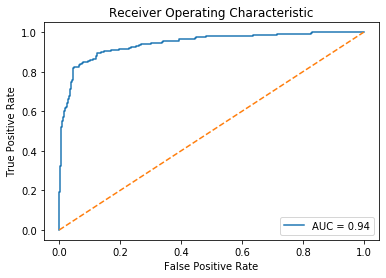

In [53]:
probabilities = clf.predict_proba(X_test)
calculate_auc(probabilities)

<h3>Try building a CNN using TensorFlow</h3>

In [15]:
cnn_X = np.array(clover)
cnn_y = np.array(labels)
cnn_y = cnn_y.reshape(-1,1)
cnn_X = cnn_X / 255.0

X_train, X_test, y_train, y_test = train_test_split(cnn_X,
                                                    cnn_y,
                                                    test_size=.3,
                                                    random_state=1234123)

print(X_train.shape)
print(X_test.shape)


(6070, 60, 60, 3)
(2602, 60, 60, 3)


In [16]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import datasets, layers, models

In [17]:


model = Sequential()


model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(60, 60, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
190/190 [==============================] - 19s 98ms/step - loss: 0.3837 - accuracy: 0.8343 - val_loss: 0.2658 - val_accuracy: 0.8901
Epoch 2/10
190/190 [==============================] - 18s 97ms/step - loss: 0.2308 - accuracy: 0.9084 - val_loss: 0.2064 - val_accuracy: 0.9139
Epoch 3/10
190/190 [==============================] - 18s 96ms/step - loss: 0.2063 - accuracy: 0.9176 - val_loss: 0.1945 - val_accuracy: 0.9231
Epoch 4/10
190/190 [==============================] - 18s 96ms/step - loss: 0.1792 - accuracy: 0.9250 - val_loss: 0.2088 - val_accuracy: 0.9170
Epoch 5/10
190/190 [==============================] - 18s 96ms/step - loss: 0.1769 - accuracy: 0.9306 - val_loss: 0.2231 - val_accuracy: 0.9116
Epoch 6/10
190/190 [==============================] - 19s 99ms/step - loss: 0.1517 - accuracy: 0.9392 - val_loss: 0.1735 - val_accuracy: 0.9316
Epoch 7/10
190/190 [==============================] - 18s 96ms/step - loss: 0.1210 - accuracy: 0.9539 - val_loss: 0.1734 - val_accuracy:

82/82 - 2s - loss: 0.1526 - accuracy: 0.9500


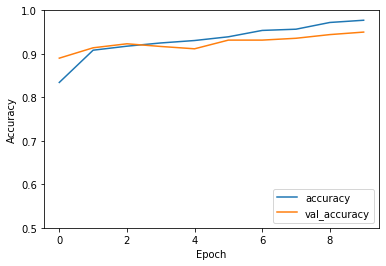

In [18]:

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)